# Karrie Meter
## Notebook Written by Jared Rennie
## Karrie Meter Developed by Nick Lilja, Nicleblock Forecast
https://www.nickelblock.com/wx-info-what-is-the-karrie-meter-how-it-came-to-be-where-it-will-go-next/

## Import Packages

In [1]:
# Import packages
import math, s3fs
import numpy as np
import xarray as xr

import sounderpy as spy
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings("ignore")

print('SUCCESS')


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                   v3.1.0 | October 2025 | (C) Kyle J Gillett                     ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##

SUCCESS


The Karrie Meter is:
+ (Surface Dewpoint / Historical Average) +
+ (Helicity / Historical Average) +
+ (ML CAPE / Historical Average) +
+ ((3k shear + 6k Shear) / Historical Average) + 
+ ((Absolute Value of 850mb Temp – 500mb Temp) / Historical Average) -
+ 3
___________________________

## Get Historical Average
+ Surface Dewpoint = 13 (From reanalysis of past local events forecast)
+ Helicity = 250 (From the Tornado Environment Browser)
+ CAPE = 600 (From the Tornado Environment Browser)
+ 3k + 6k Shear = 80 (From the Tornado Environment Browser)
+ Absolute Value of 850mb Temp – 500mb Temp = 20 (From reanalysis of past local events forecast)

In [2]:
# Define KM Averages
Avg_sfcTd=13.
Avg_hel=250.
Avg_mlCAPE=600.
Avg_shear36=80.
Avg_tempDiff=20.

## Sounding Analysis (Observed Data)

In [3]:
# Read In Sounding Data
# JAN = Jackson, Mississippi
inStn = 'JAN' 
inYear  = '2011' 
inMonth = '04'
inDay   = '27'
inHour  = '18'

inData = spy.get_obs_data(inStn, inYear, inMonth, inDay, inHour)
print('SUCCESS')

> OBSERVED DATA ACCESS FUNCTION
  -----------------------------------
    > PROFILE FOUND: JAN on 04/27/2011 at 18z | From UW
    > COMPLETE --------
    > RUNTIME: 00:00:01
    > SUMMARY: 18Z Launch for KJAN, JACKSON at 04-27-2011-18Z
 
    > THERMODYNAMICS --------------------------------------------- 
    --- SBCAPE: 3808.5 | MUCAPE: 4016.7 | MLCAPE: 3366.7 | MUECAPE: 3492.2
    --- MU 0-3: 208.5 | MU 0-6: 1030.1 | SB 0-3: 187.8 | SB 0-6: 975.0
 
    > KINEMATICS ------------------------------------------------- 
    --- 0-500 SRW: 43.2 knot | 0-500 SWV: 0.032 | 0-500 SHEAR: 31.7 | 0-500 SRH: 289.7
    --- 1-3km SRW: 22.7 knot | 1-3km SWV: 0.005 | 1-3km SHEAR: 21.7 | | 1-3km SRH: 99.9
 
SUCCESS


### Plot (For Funsies)

> SOUNDING PLOTTER FUNCTION
  ---------------------------------
- no radar data available -
    > COMPLETE --------
    > RUNTIME: 00:00:11


posx and posy should be finite values
posx and posy should be finite values


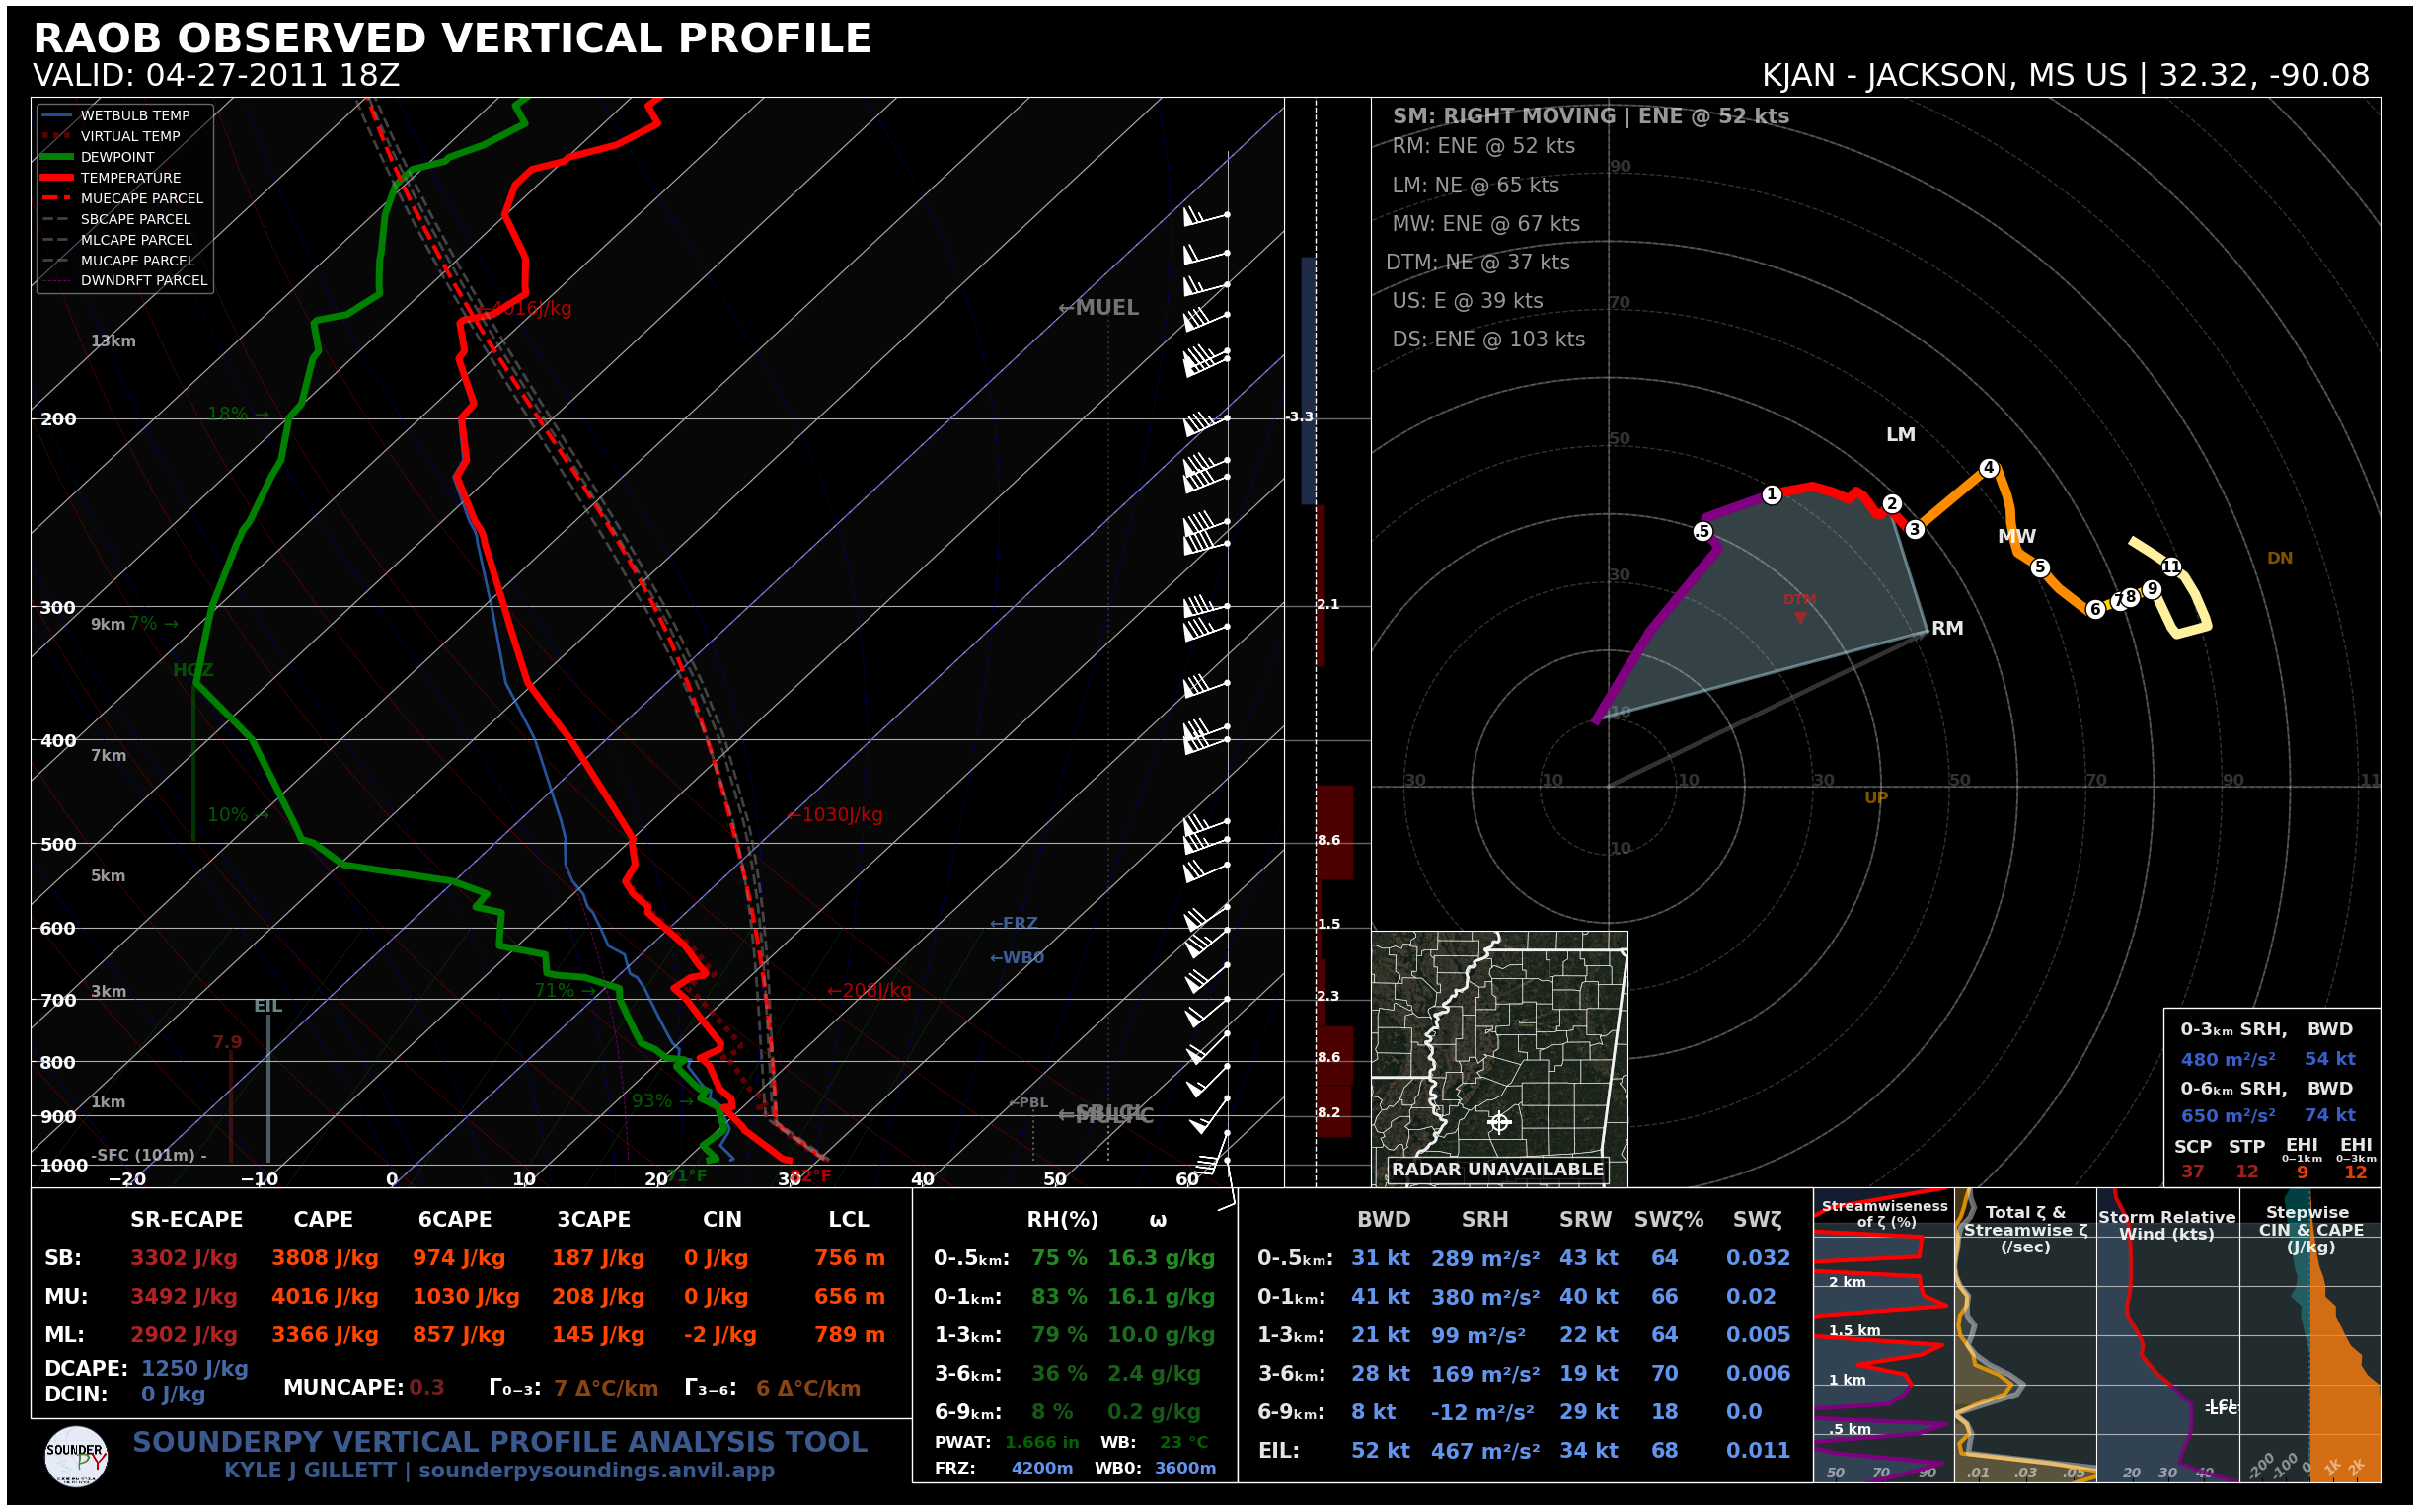

SUCCESS


In [4]:
# Plot (For Funsies)
spy.build_sounding(inData, dark_mode=True)
print('SUCCESS')

### Get Variables for Karrie Meter
**WARNING: Made some assumptions here, so might have to double check and confirm**

In [5]:
# Get specific data for Karrie Meter
inParams=spy.sounding_params(inData).calc()

# Get Specific Parameters (Already Calculated by SounderPy)
sfcTd=float(inData['Td'].magnitude[0])
hel=float(inParams[2]['srh_0_to_1000'])
mlCAPE=float(inParams[1]['mlcape'])

# Shear (3k and 6k)
shear3=float(inParams[2]['shear_0_to_3000'])
shear6=float(inParams[2]['shear_0_to_6000'])
shear36=shear3+shear6

# locate 850/500 mb and get T
loc850=np.where(inData['p'].magnitude==850)
loc500=np.where(inData['p'].magnitude==500)
tempDiff=float(np.abs(inData['T'].magnitude[loc850] - inData['T'].magnitude[loc500])[0])

print('Surface Dewpoint: ',sfcTd, ' | AVERAGE: ',Avg_sfcTd)
print('Storm Relative Helcity (0-1km): ',hel, ' | AVERAGE: ',Avg_hel)
print('MLCAPE: ',mlCAPE, ' | AVERAGE: ',Avg_mlCAPE)
print('Shear (3+6km): ',shear36, ' | AVERAGE: ',Avg_shear36)
print('Abs(850mb T Minus 500mb Temp)',tempDiff, ' | AVERAGE: ',Avg_tempDiff)

Surface Dewpoint:  21.8  | AVERAGE:  13.0
Storm Relative Helcity (0-1km):  380.8030831945192  | AVERAGE:  250.0
MLCAPE:  3366.7355093204064  | AVERAGE:  600.0
Shear (3+6km):  129.3366007376609  | AVERAGE:  80.0
Abs(850mb T Minus 500mb Temp) 26.5  | AVERAGE:  20.0


### Calculate Karrie Meter

In [6]:
# Calculate Karrie Meter
KM1= (sfcTd/Avg_sfcTd) + (hel/Avg_hel) + (mlCAPE/Avg_mlCAPE) + (shear36/Avg_shear36) + (tempDiff/Avg_tempDiff)

# Same thing, but minus 3 for... reasons
KM2=KM1-3

print(KM1,KM2)

11.753068767789259 8.753068767789259


## Sounding Analysis (Forecast Data)

Models Available in SounderPy
- hrrr: High Resolution Rapid Refresh, analysis (F00) & forecast; out to forecast hour 48
- rap: Rapid Refresh Model, analysis (F00) & forecast; out to forecast hour 51
- nam: North American Mesoscale Model, analysis (F00) & forecast; out to forecast hour 48
- namnest: Nested North American Mesoscale model, analysis (F00) & forecast; out to forecast hour 60
- gfs: Global Forecast System, analysis (F00) & forecast; out to forecast hour 180
- sref: Short Range Ensemble Forecast, analysis (F00) & forecast; out to forecast hour 84
- hiresw: High Resolution Window Forecast System, analysis (F00) & forecast; out to forecast hour 48

In [7]:
# Read In Forecast sounding Data
# khbg = Hattiesburg, Mississippi
inModel='gfs'
inStn = 'khbg' 
runYear  = '2023'
runMonth = '03'
runDay   = '31'
runHour  = '12'
inFcsrHour=6

inFcst = spy.get_bufkit_data(inModel, inStn, inFcsrHour, run_year=runYear, run_month=runMonth, run_day=runDay, run_hour=runHour)
print('SUCCESS')

> BUFKIT DATA ACCESS FUNCTION
   ---------------------------------
    > COMPLETE --------
    > RUNTIME: 00:00:00
    > SUMMARY: SUMMARY: 12Z GFS F06 for KHBG,CHAIN MUNICIPAL AIRPORT at 03-31-2023-18Z
 
    > THERMODYNAMICS --------------------------------------------- 
    --- SBCAPE: 1067.7 | MUCAPE: 1067.7 | MLCAPE: 573.7 | MUECAPE: 906.7
    --- MU 0-3: 0.0 | MU 0-6: 355.5 | SB 0-3: 0.0 | SB 0-6: 355.5
 
    > KINEMATICS ------------------------------------------------- 
    --- 0-500 SRW: 28.5 knot | 0-500 SWV: 0.018 | 0-500 SHEAR: 17.9 | 0-500 SRH: 124.1
    --- 1-3km SRW: 16.6 knot | 1-3km SWV: 0.006 | 1-3km SHEAR: 28.5 | | 1-3km SRH: 131.2
 
SUCCESS


### Plot (For More Funsies)

> SOUNDING PLOTTER FUNCTION
  ---------------------------------
- no radar data available -
    > COMPLETE --------
    > RUNTIME: 00:00:11


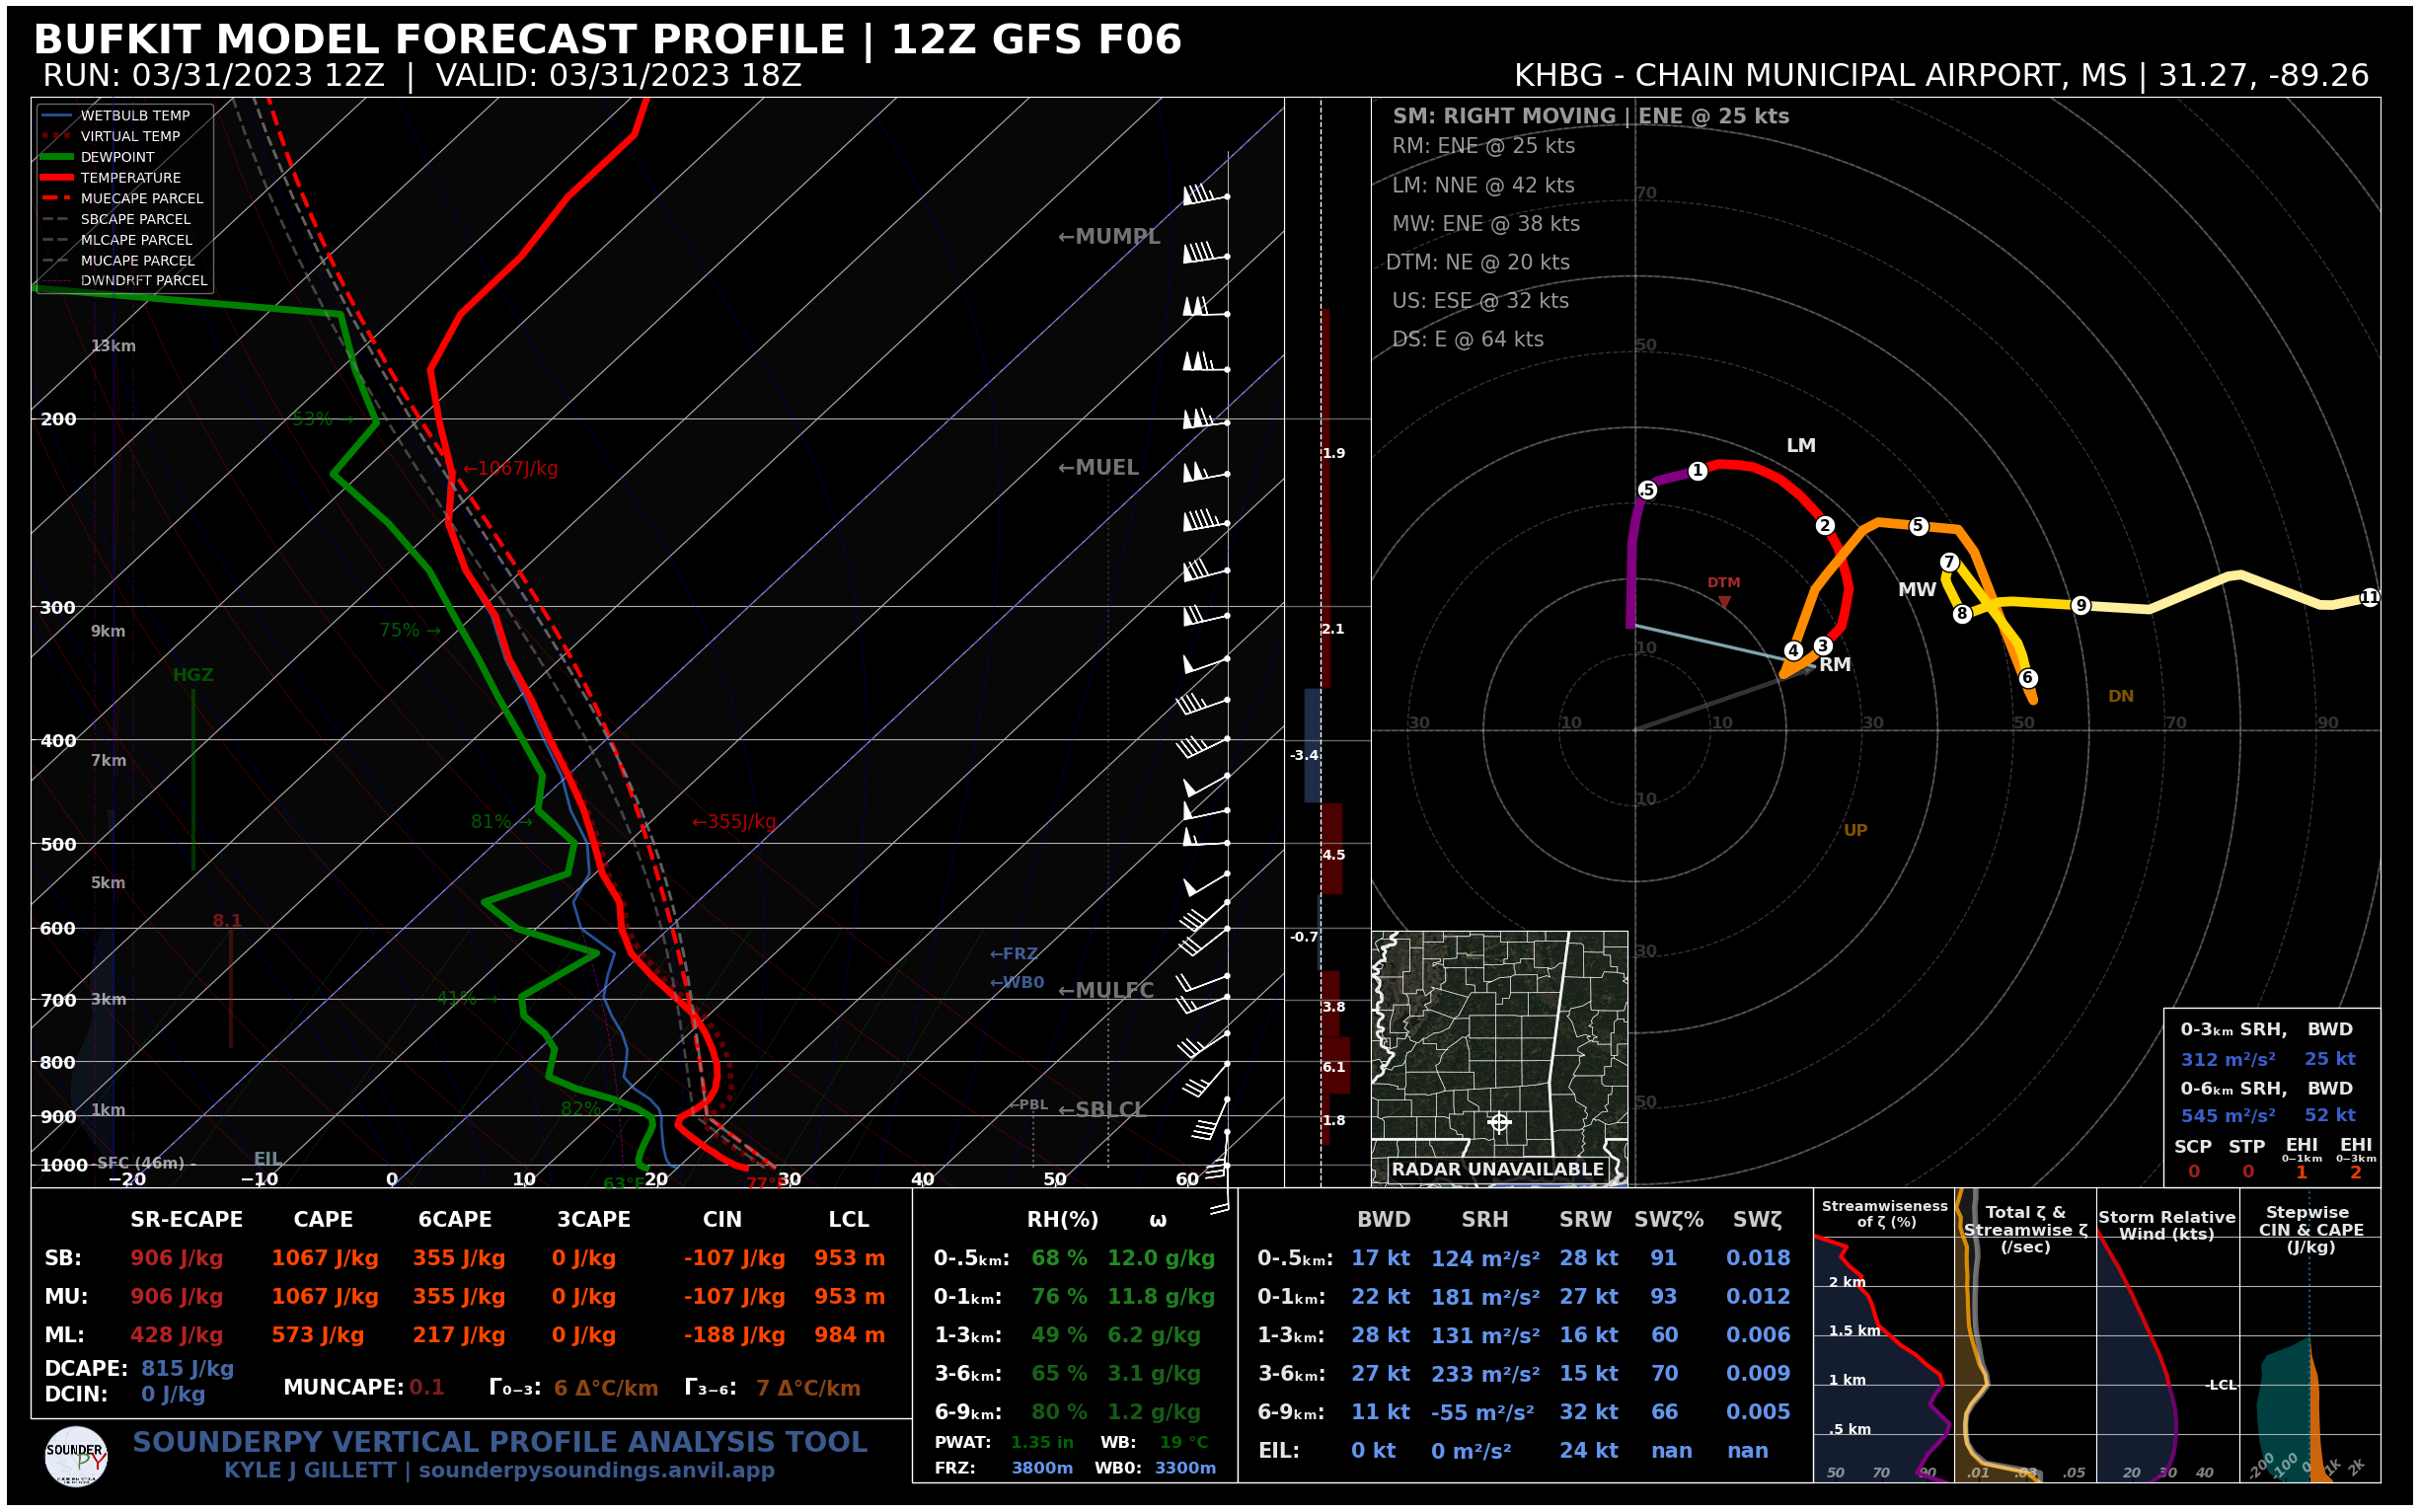

SUCCESS


In [8]:
# Plot (For More Funsies)
spy.build_sounding(inFcst, dark_mode=True)
print('SUCCESS')

### Get Variables for Karrie Meter
**WARNING: Made some assumptions here, so might have to double check and confirm**

In [9]:
# Get specific data for Karrie Meter
inParams=spy.sounding_params(inFcst).calc()

# Get Specific Parameters (Already Calculated by SounderPy)
sfcTd=float(inData['Td'].magnitude[0])
hel=float(inParams[2]['srh_0_to_1000'])
mlCAPE=float(inParams[1]['mlcape'])

# Shear (3k and 6k)
shear3=float(inParams[2]['shear_0_to_3000'])
shear6=float(inParams[2]['shear_0_to_6000'])
shear36=shear3+shear6

# locate 850/500 mb and get T
loc850=np.where(inData['p'].magnitude==850)
loc500=np.where(inData['p'].magnitude==500)
tempDiff=float(np.abs(inData['T'].magnitude[loc850] - inData['T'].magnitude[loc500])[0])

print('Surface Dewpoint: ',sfcTd, ' | AVERAGE: ',Avg_sfcTd)
print('Storm Relative Helcity (0-1km): ',hel, ' | AVERAGE: ',Avg_hel)
print('MLCAPE: ',mlCAPE, ' | AVERAGE: ',Avg_mlCAPE)
print('Shear (3+6km): ',shear36, ' | AVERAGE: ',Avg_shear36)
print('Abs(850mb T Minus 500mb Temp)',tempDiff, ' | AVERAGE: ',Avg_tempDiff)

Surface Dewpoint:  21.8  | AVERAGE:  13.0
Storm Relative Helcity (0-1km):  181.0159450305861  | AVERAGE:  250.0
MLCAPE:  573.6847076501356  | AVERAGE:  600.0
Shear (3+6km):  78.57639744151534  | AVERAGE:  80.0
Abs(850mb T Minus 500mb Temp) 26.5  | AVERAGE:  20.0


### Calculate Karrie Meter

In [10]:
# Calculate Karrie Meter
KM1= (sfcTd/Avg_sfcTd) + (hel/Avg_hel) + (mlCAPE/Avg_mlCAPE) + (shear36/Avg_shear36) + (tempDiff/Avg_tempDiff)

# Same thing, but minus 3 for... reasons
KM2=KM1-3

print(KM1,KM2)

5.664333004481256 2.6643330044812563


## Model Data Spatial Plot using NAM or HRRR (example uses NAM)

Using Herbie 
- https://github.com/blaylockbk/Herbie
- https://herbie.readthedocs.io/en/stable/

Models in Herbie (more than NAM or HRRR, but only developed with these two)
- See https://herbie.readthedocs.io/en/latest/gallery/index.html
- GRIB codes: https://codes.ecmwf.int/grib/param-db/

In [11]:
# Define Model Info
inModel='nam'
runYear  = 2025
runMonth = 3
runDay   = 14
runHour  = 12
inFcstHour=30

# Get Run Date from Inputs above
runDate = "{:04d}-{:02d}-{:02d} {:02d}:00".format(runYear,runMonth,runDay,runHour)
print('Model Init: ',runDate,'UTC | FCST Hour: ',inFcstHour)

# Get Model Version (See https://herbie.readthedocs.io/en/latest/gallery/index.html)
if inModel=='hrrr':
    inProduct='sfc'
if inModel=='nam':
    inProduct='conusnest.hiresf'
    
# Create a Herbie object for model data
H = Herbie(
    runDate,        # Date and time
    model=inModel,  # Model name
    product=inProduct,  # Product type
    fxx=inFcstHour  # Forecast hour
)
print("SUCCESS")

Model Init:  2025-03-14 12:00 UTC | FCST Hour:  30
✅ Found ┊ model=nam ┊ product=conusnest.hiresf ┊ 2025-Mar-14 12:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ local
SUCCESS


### Investigate Model Variables (Each model is different)

In [12]:
# Check Inventory
modelInv=H.inventory()

# Visual 1: Some Variabes
modelInv

# Visual 2: ALL Variables
#for index, row in modelInv.iterrows():
#    print(row['search_this'])

# Visual 3: Specific Variable
# For Karrie Meter: TMP, DPT, CAPE, HLCY, VUCSH, VVCSH
# See all codes: https://codes.ecmwf.int/grib/param-db/
#var='TMP'
#testVar=modelInv[modelInv['variable']==var]
#testVar

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1.0,0,2.559517e+06,0-2559517,2025-03-14 12:00:00,2025-03-15 18:00:00,PRMSL,mean sea level,30 hour fcst,:PRMSL:mean sea level:30 hour fcst
1,2.0,2559518,3.379397e+06,2559518-3379397,2025-03-14 12:00:00,2025-03-15 18:00:00,REFD,263 K level,30 hour fcst,:REFD:263 K level:30 hour fcst
2,3.0,3379398,5.808774e+06,3379398-5808774,2025-03-14 12:00:00,2025-03-15 18:00:00,PRES,1 hybrid level,30 hour fcst,:PRES:1 hybrid level:30 hour fcst
3,4.0,5808775,6.261831e+06,5808775-6261831,2025-03-14 12:00:00,2025-03-15 18:00:00,CLMR,1 hybrid level,30 hour fcst,:CLMR:1 hybrid level:30 hour fcst
4,5.0,6261832,6.507497e+06,6261832-6507497,2025-03-14 12:00:00,2025-03-15 18:00:00,CICE,1 hybrid level,30 hour fcst,:CICE:1 hybrid level:30 hour fcst
...,...,...,...,...,...,...,...,...,...,...
871,806.0,1071496971,1.072327e+09,1071496971-1072326814,2025-03-14 12:00:00,2025-03-15 18:00:00,WEASD,surface,30 hour fcst,:WEASD:surface:30 hour fcst
872,807.0,1072326815,1.073407e+09,1072326815-1073406870,2025-03-14 12:00:00,2025-03-15 18:00:00,SNOD,surface,30 hour fcst,:SNOD:surface:30 hour fcst
873,808.0,1073406871,1.074233e+09,1073406871-1074233297,2025-03-14 12:00:00,2025-03-15 18:00:00,APCP,surface,27-30 hour acc fcst,:APCP:surface:27-30 hour acc fcst
874,809.0,1074233298,1.074692e+09,1074233298-1074692129,2025-03-14 12:00:00,2025-03-15 18:00:00,WEASD,surface,27-30 hour acc fcst,:WEASD:surface:27-30 hour acc fcst


### Get Variables for Karrie Meter
**WARNING: Made some assumptions here, so might have to double check and confirm**

In [13]:
# Get Lat/Lons (For plotting later)
test=H.xarray("TMP:2 m above ground")
lats=test['latitude'].values
lons=test['longitude'].values

# Get Specific Parameters 
# Surface Td
sfcTd = H.xarray("DPT:2 m above ground")
sfcTd=(sfcTd['d2m'].values) - 273.15

# Helicity (assuming 0-1km)
hel = H.xarray("HLCY:1000-0 m above ground")
hel=hel['hlcy'].values

# Mixed Layer CAPE (Assuming 180-0mb)
mlCAPE = H.xarray("CAPE:180-0 mb above ground")
mlCAPE=mlCAPE['cape'].values

# T850-T500
temp850 = H.xarray("TMP:850 mb")
temp500 = H.xarray("TMP:500 mb")
tempDiff=np.abs(temp850-temp500)
tempDiff=tempDiff['t'].values

# Shear (3km + 6km)
#    - HRRR, no 3km easily, so using 1km
#    - NAM, only 6km?
if inModel=='hrrr':
    u1=H.xarray("VUCSH:0-1000 m above ground")['vucsh'].values
    v1=H.xarray("VVCSH:0-1000 m above ground")['vvcsh'].values
    u2=H.xarray("VUCSH:0-6000 m above ground")['vucsh'].values
    v2=H.xarray("VVCSH:0-6000 m above ground")['vvcsh'].values
if inModel=='nam':
    u1=H.xarray("VUCSH:0-6000 m above ground")['vucsh'].values
    v1=H.xarray("VVCSH:0-6000 m above ground")['vvcsh'].values
    u2=H.xarray("VUCSH:0-6000 m above ground")['vucsh'].values
    v2=H.xarray("VVCSH:0-6000 m above ground")['vvcsh'].values
shear1=np.sqrt( (u1**2) + (v1**2) )
shear2=np.sqrt( (u2**2) + (v2**2) )
outShear=shear1+shear2

print('SUCCESS')

SUCCESS


### Calculate Karrie Meter

In [14]:
# Calculate Karrie Meter
KM1= (sfcTd/Avg_sfcTd) + (hel/Avg_hel) + (mlCAPE/Avg_mlCAPE) + (outShear/Avg_shear36) + (tempDiff/Avg_tempDiff)

# Same thing, but minus 3 for... reasons
KM2=KM1-3

print(KM1)
print('MAX: ',np.nanmax(KM1),'\n')
print(KM2)
print('MAX: ',np.nanmax(KM2),'\n')

[[2.2627082 2.2562509 2.2544522 ...       nan       nan       nan]
 [2.2627082 2.2562509 2.2544522 ...       nan       nan       nan]
 [2.3370683 2.3329911 2.3098283 ...       nan       nan       nan]
 ...
 [2.2917073 2.1257327 2.1649404 ... 1.4212393 1.4349215 1.4387066]
 [2.1887016 2.1843166 2.387071  ... 1.4086342 1.4078404 1.4078404]
 [2.227515  2.4304955 2.7526693 ... 1.3826032 1.3826032 1.3868998]]
MAX:  12.752785 

[[-0.7372918  -0.74374914 -0.7455478  ...         nan         nan
          nan]
 [-0.7372918  -0.74374914 -0.7455478  ...         nan         nan
          nan]
 [-0.6629317  -0.6670089  -0.6901717  ...         nan         nan
          nan]
 ...
 [-0.7082927  -0.87426734 -0.83505964 ... -1.5787607  -1.5650785
  -1.5612934 ]
 [-0.8112984  -0.81568336 -0.6129291  ... -1.5913658  -1.5921596
  -1.5921596 ]
 [-0.772485   -0.5695045  -0.24733067 ... -1.6173968  -1.6173968
  -1.6131002 ]]
MAX:  9.752785 



### Plot Spatial Map (centered on Mississippi)

PLOTTING


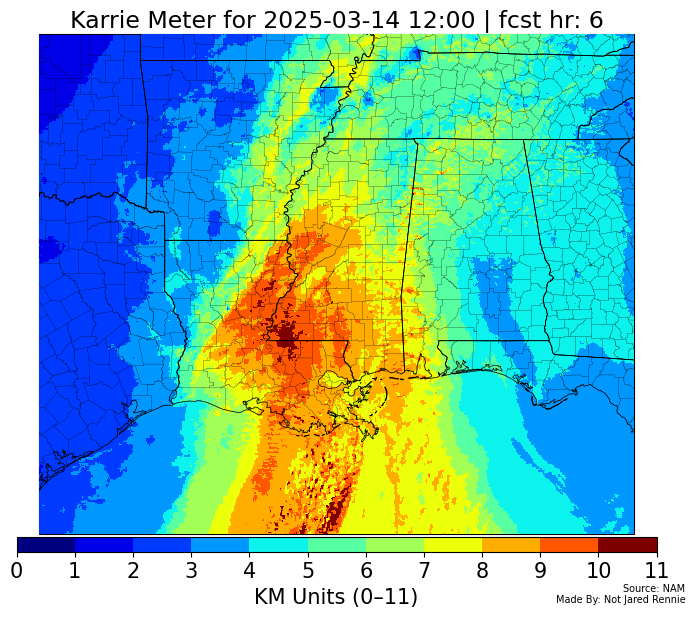

In [15]:
#################################################
# Plotting parameters
unit = 'KM Units (0–11)'  
element_name = 'Karrie Meter'
ocean_hex = '#ececeb'
land_hex = '#d2d6d6'
dpi = 100
colorMap = 'jet' # This color map sucks, please choose a better one :)
author = 'Not Jared Rennie'

# --- Discrete colormap: exactly 12 colors (0–11) ---
bounds = np.arange(0, 12, 1, dtype='f')  # 12 bins for 0–11
cmap = plt.get_cmap(colorMap, len(bounds))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

#################################################
# PLOTTING
print("PLOTTING")

# Set Bounds
minLat = 27    
maxLat = 37   
minLon = -97 
maxLon = -83 

# Set Up Figure
fig = plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)

# Add Boundaries
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, facecolor=land_hex, zorder=9)
ax.add_feature(cfeature.STATES, linewidth=0.5, zorder=10)
ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.10,edgecolor='black',facecolor='None',zorder=10)

# Plot Data
mesh = ax.pcolormesh(lons, lats, KM1, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=9)
#mesh = ax.pcolormesh(lons, lats, KM2, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=9)

# --- Add Colorbar ---
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar = plt.colorbar(mesh, cax=cax, boundaries=bounds,ticks=np.arange(0, 12, 1),
    orientation='horizontal', extend='neither', spacing='proportional')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(unit, size=15)

# Annotate Info On Graphic
plt.annotate('Source: ' + inModel.upper() + '\nMade By: ' + author, xy=(1.045, -3.51), xycoords='axes fraction',
    fontsize=7, color='black', horizontalalignment='right', verticalalignment='bottom')

# Add Title and Save to File
plt.suptitle(element_name + ' for ' + runDate + ' | fcst hr: ' + str(inFcsrHour),size=17,color='black',y=1.05) 
plt.savefig('km_'+inModel+'_'+runDate.replace(' ','-')+'-fcst'+str(inFcsrHour)+'.png', bbox_inches='tight', dpi=dpi)
plt.show()
plt.clf()
plt.close()